# Instacart customer segmentation and order prediction
Niaoniao Ma, Peilun (Ann) Liu, Susannah Schulze

### Import data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import scoreatpercentile
import seaborn as sns
import math
import sklearn.preprocessing as skp
import sklearn.cluster as skc
import sklearn.metrics as skm
#import sklearn.manifold.TSNE
color = sns.color_palette()

In [2]:
# Load data
aisles = pd.read_csv("aisles.csv")
departments = pd.read_csv("departments.csv")
orders_prior = pd.read_csv("order_products__prior.csv")
orders_train = pd.read_csv("order_products__train.csv")
orders = pd.read_csv("orders.csv")
products = pd.read_csv("products.csv")

In [3]:
orders_prior.shape

(32434489, 4)

In [3]:
# Concatenate orders_prior and orders_train
orders_products = pd.concat([orders_prior,orders_train])

In [5]:
orders_products.head(10)

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
5,2,17794,6,1
6,2,40141,7,1
7,2,1819,8,1
8,2,43668,9,0
9,3,33754,1,1


# Exploratory Data Analysis (EDA)

## Products per Order

In [6]:
orders_products.isnull().sum()

order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64

In [7]:
# Make a counts table to visualize # products per order
product_counts = orders_products.groupby('order_id').count()

In [8]:
product_counts.head(10)

,product_id,add_to_cart_order,reordered
order_id,,,
1,8,8,8
2,9,9,9
3,8,8,8
4,13,13,13
5,26,26,26
6,3,3,3
7,2,2,2
8,1,1,1
9,15,15,15


In [9]:
products.head(10)

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13
5,6,Dry Nose Oil,11,11
6,7,Pure Coconut Water With Orange,98,7
7,8,Cut Russet Potatoes Steam N' Mash,116,1
8,9,Light Strawberry Blueberry Yogurt,120,16
9,10,Sparkling Orange Juice & Prickly Pear Beverage,115,7


{'whiskers': [<matplotlib.lines.Line2D at 0x7f8e32c1e490>,
 'caps': [<matplotlib.lines.Line2D at 0x7f8e32c30b90>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f8e32c10190>],
 'medians': [<matplotlib.lines.Line2D at 0x7f8e32c3c610>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f8e32c1e290>],
 'means': []}

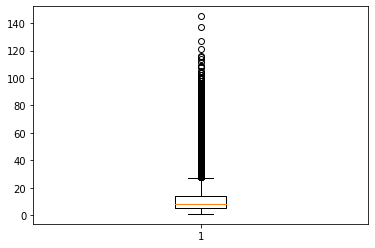

In [10]:
plt.boxplot(product_counts['product_id'])

(array([2.696216e+06, 5.690350e+05, 7.299100e+04, 6.739000e+03,
        8.790000e+02, 1.560000e+02, 4.900000e+01, 1.400000e+01,
        2.000000e+00, 2.000000e+00]),
 array([  1. ,  15.4,  29.8,  44.2,  58.6,  73. ,  87.4, 101.8, 116.2,
        130.6, 145. ]),
 <a list of 10 Patch objects>)

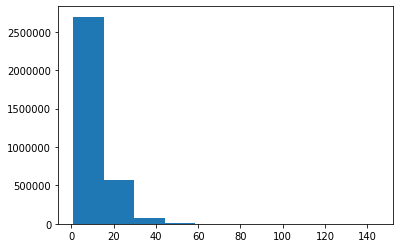

In [11]:
plt.hist(product_counts['product_id'])

In [12]:
# Find the mean products per order
product_counts['product_id'].mean()

10.10707325550502

In [13]:
# Find the mode products per order
product_counts['product_id'].mode()

0    5
dtype: int64

In [14]:
# Find the median products per order
product_counts['product_id'].median()

8.0

In [15]:
# IQR products per order
q1 = scoreatpercentile(product_counts['product_id'],25)
q3 = scoreatpercentile(product_counts['product_id'],75)
[q1,q3]

[5.0, 14.0]

## Products Reordered

In [16]:
# Find percentage of orders that had reordered products
orders_with_re = orders_products.groupby('order_id')['reordered'].sum()
orders_with_re.head(5)

order_id
1     4
2     6
3     8
4    12
5    21
Name: reordered, dtype: int64

In [17]:
(len(orders_with_re)-len(orders_with_re[orders_with_re == 0]))/len(orders_with_re)

0.8813194412690899

In [18]:
# Find number of times each product has been reordered
reordered_products = orders_products.groupby('product_id')['reordered'].sum()

In [19]:
reordered_products.head(10)

product_id
1     1185
2       13
3      209
4      161
5       10
6        3
7       13
8       90
9       84
10    1374
Name: reordered, dtype: int64

In [20]:
# Find the most reordered products
reordered_productsname = pd.merge(reordered_products, products, on = 'product_id', how = 'left')

In [21]:
reordered_productsname.sort_values('reordered',ascending=False).head(10)

,product_id,reordered,product_name,aisle_id,department_id
24849,24852,415166,Banana,24,4
13173,13176,329275,Bag of Organic Bananas,24,4
21134,21137,214448,Organic Strawberries,24,4
21900,21903,194939,Organic Baby Spinach,123,4
47205,47209,176173,Organic Hass Avocado,24,4
47762,47766,140270,Organic Avocado,24,4
27842,27845,118684,Organic Whole Milk,84,16
47622,47626,112178,Large Lemon,24,4
27963,27966,109688,Organic Raspberries,123,4
16794,16797,104588,Strawberries,24,4


Main findings of orders_products table
1. IQR (75%) of number products per order is 5-14 products.
2. Distribution of number of products per order is right-skewed with a mean of 10.11 and a mode of 5.
3. 88% of orders include reordered products.
4. Select fruits and milk are among the most reordered products.

In [22]:
# Total and average number of products purchased per customer
orders_products_cust = pd.merge(orders_products, orders[['order_id','user_id']],on = 'order_id')

In [23]:
cust_products = orders_products_cust.groupby(['user_id'])['product_id'].count()
orders_per_customer = orders_products_cust.groupby(['user_id'])['order_id'].nunique()

In [24]:
orders_products_cust.head(10)

,order_id,product_id,add_to_cart_order,reordered,user_id
0,2,33120,1,1,202279
1,2,28985,2,1,202279
2,2,9327,3,0,202279
3,2,45918,4,1,202279
4,2,30035,5,0,202279
5,2,17794,6,1,202279
6,2,40141,7,1,202279
7,2,1819,8,1,202279
8,2,43668,9,0,202279
9,3,33754,1,1,205970


## Products

In [25]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49688 entries, 0 to 49687
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product_id     49688 non-null  int64 
 1   product_name   49688 non-null  object
 2   aisle_id       49688 non-null  int64 
 3   department_id  49688 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


In [26]:
products.isnull().sum()

product_id       0
product_name     0
aisle_id         0
department_id    0
dtype: int64

In [27]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8dc34d10d0>]],
      dtype=object)

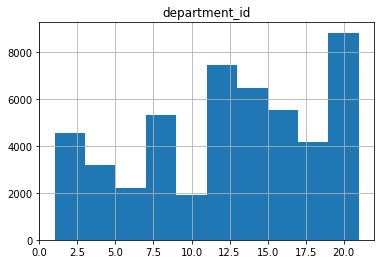

In [28]:
products.hist(column = 'department_id')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8dc357fa50>]],
      dtype=object)

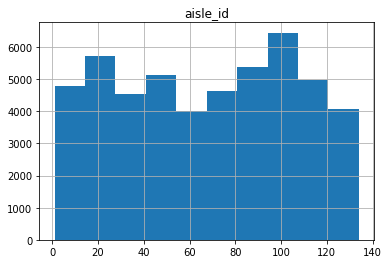

In [29]:
products.hist(column='aisle_id')

In [4]:
prod_dept = pd.merge(products, departments, on = 'department_id', how = 'left')
prod_dept.head()

,product_id,product_name,aisle_id,department_id,department
0,1,Chocolate Sandwich Cookies,61,19,snacks
1,2,All-Seasons Salt,104,13,pantry
2,3,Robust Golden Unsweetened Oolong Tea,94,7,beverages
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,frozen
4,5,Green Chile Anytime Sauce,5,13,pantry


In [5]:
prod_dept_aisle = pd.merge(prod_dept, aisles, on = 'aisle_id', how = 'left')
prod_dept_aisle.head()

,product_id,product_name,aisle_id,department_id,department,aisle
0,1,Chocolate Sandwich Cookies,61,19,snacks,cookies cakes
1,2,All-Seasons Salt,104,13,pantry,spices seasonings
2,3,Robust Golden Unsweetened Oolong Tea,94,7,beverages,tea
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,frozen,frozen meals
4,5,Green Chile Anytime Sauce,5,13,pantry,marinades meat preparation


What are the most common aisles and departments? Note: these are what the supermarket offers, not what is ordered.

In [32]:
cnt_aisle = prod_dept_aisle['aisle'].value_counts().reset_index().head(20)
cnt_aisle.columns = ['aisle', 'count']
cnt_aisle

,aisle,count
0,missing,1258
1,candy chocolate,1246
2,ice cream ice,1091
3,vitamins supplements,1038
4,yogurt,1026
5,chips pretzels,989
6,tea,894
7,packaged cheese,891
8,frozen meals,880
9,cookies cakes,874


In [33]:
cnt_dept = prod_dept_aisle['department'].value_counts().reset_index()
cnt_dept.columns = ['department', 'count']
cnt_dept

,department,count
0,personal care,6563
1,snacks,6264
2,pantry,5371
3,beverages,4365
4,frozen,4007
5,dairy eggs,3449
6,household,3085
7,canned goods,2092
8,dry goods pasta,1858
9,produce,1684


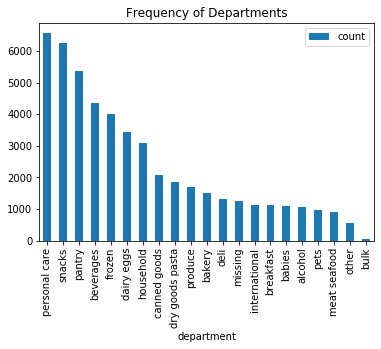

In [34]:
cnt_dept.plot.bar(x = 'department', y = 'count', title = "Frequency of Departments")

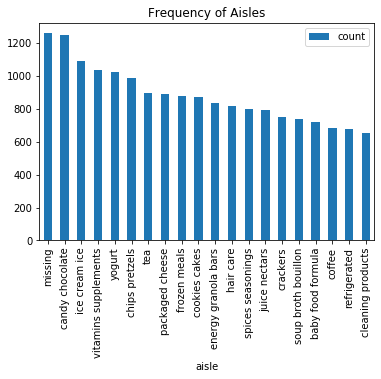

In [35]:
cnt_aisle.plot.bar(x = 'aisle', y = 'count', title = "Frequency of Aisles")

Takeaways:


*   1258 products have aisle of 'missing'
*   The personal care, snacks, and pantry departments have the most items
*   The candy chocolate, ice cream ice, and vitamin supplements aisles have the most product variety



## Orders

In [36]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3421083 entries, 0 to 3421082
Data columns (total 7 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   user_id                 int64  
 2   eval_set                object 
 3   order_number            int64  
 4   order_dow               int64  
 5   order_hour_of_day       int64  
 6   days_since_prior_order  float64
dtypes: float64(1), int64(5), object(1)
memory usage: 182.7+ MB


In [37]:
orders['days_since_prior_order'].describe()

count    3.214874e+06
mean     1.111484e+01
std      9.206737e+00
min      0.000000e+00
25%      4.000000e+00
50%      7.000000e+00
75%      1.500000e+01
max      3.000000e+01
Name: days_since_prior_order, dtype: float64

In [38]:
## check if there is any null value in Orders table
orders.isnull().sum()

order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

### Order Time Exploration

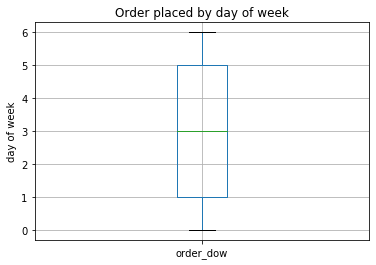

In [39]:
## Check at which day of week do customer place orders
## Most of the orders are placed at day 3 (Wednesday)
orders.boxplot('order_dow')
plt.title('Order placed by day of week')
plt.ylabel('day of week')
plt.show()

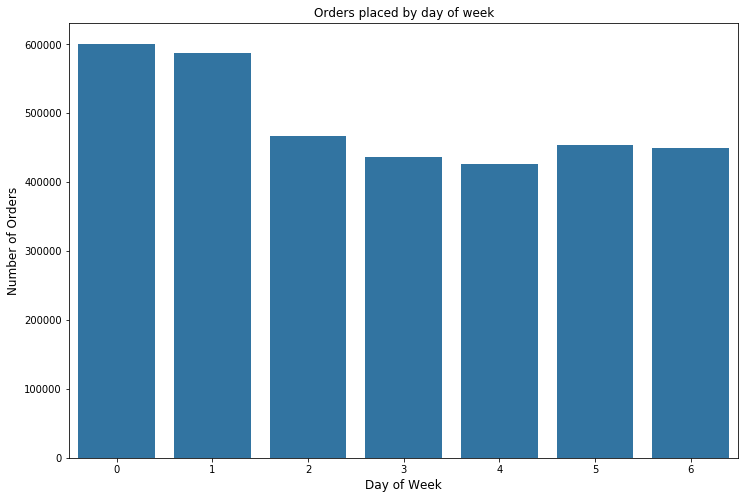

In [40]:
# code borrowed from https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-instacart
plt.figure(figsize=(12,8))
sns.countplot(x = "order_dow", data = orders, color = color[0])
plt.ylabel('Number of Orders', fontsize = 12)
plt.xlabel('Day of Week', fontsize=12)
plt.title("Orders placed by day of week")
plt.show()

More orders are placed on days 0 and 1, which could represent the weekend.

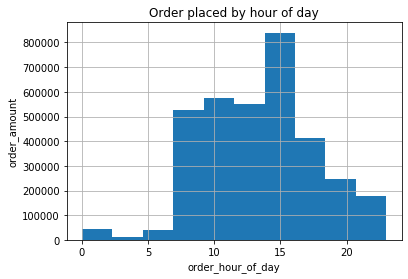

In [41]:
## Check at what time do customers order the most
## Most of the people place orders around 14:00 - 16:00
orders.hist(column='order_hour_of_day')
plt.title('Order placed by hour of day')
plt.xlabel('order_hour_of_day')
plt.ylabel('order_amount')
plt.show()

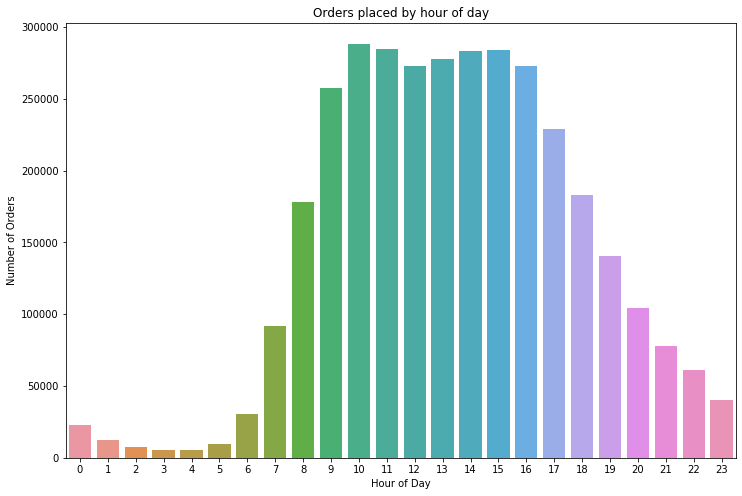

In [42]:
# code borrowed from https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-instacart
plt.figure(figsize=(12,8))
sns.countplot(x = 'order_hour_of_day', data = orders)
plt.ylabel('Number of Orders')
plt.xlabel('Hour of Day')
plt.title('Orders placed by hour of day')
plt.show()

Most of the orders are placed between 9am and 4pm.

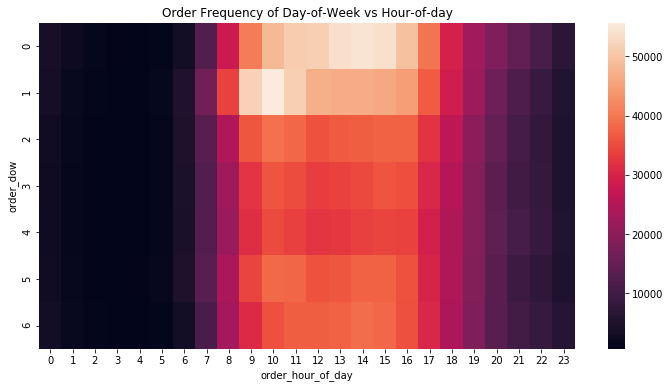

In [43]:
## Create a heat map to see Order Frequency of Day-of-Week vs Hour-of-day
grouped_orders = orders.groupby(["order_dow", "order_hour_of_day"])["order_number"].aggregate("count").reset_index()
grouped_orders = grouped_orders.pivot('order_dow', 'order_hour_of_day', 'order_number')

plt.figure(figsize=(12,6))
sns.heatmap(grouped_orders)
plt.title("Order Frequency of Day-of-Week vs Hour-of-day")
plt.show()

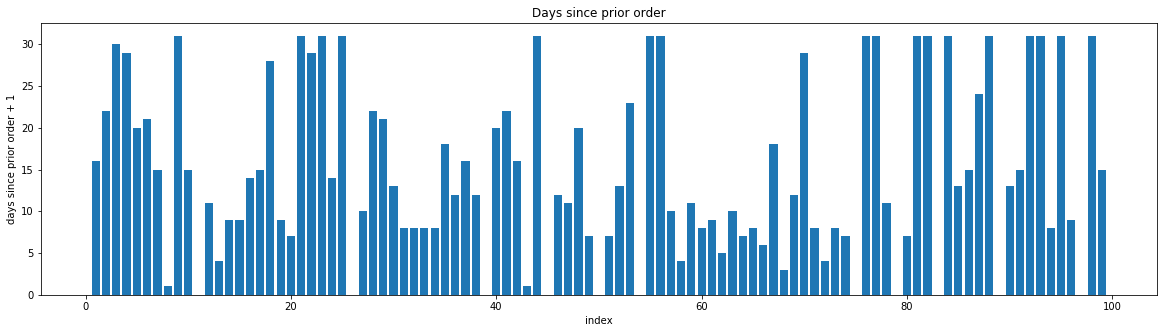

In [44]:
## Check how many days later customers returned after making the last purchase (only using the first 100 purchase or)
## This is code is referred to one of the Kaggle competition participants: https://www.kaggle.com/katharinepires/association-rules-instacart-market-basket-analysis
plt.figure(figsize = (20,5))
plt.bar(range(100), orders.days_since_prior_order[:100] + 1)
plt.title('Days since prior order')
plt.xlabel('index')
plt.ylabel('days since prior order + 1');

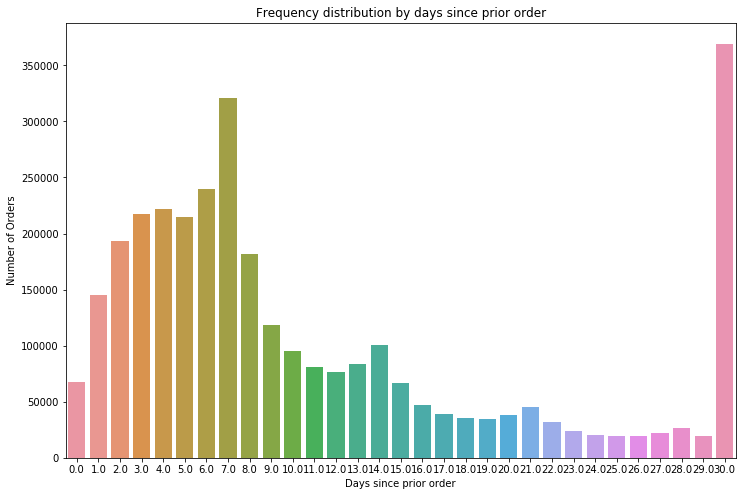

In [45]:
# code borrowed from https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-instacart
plt.figure(figsize=(12,8))
sns.countplot(x = 'days_since_prior_order', data = orders)
plt.ylabel("Number of Orders")
plt.xlabel('Days since prior order')
plt.title("Frequency distribution by days since prior order")
plt.show()

There appear to be two spikes: at the 7 day and 30 day mark which shows that customers typically reorder at the end of the week or end of the month.

### Train Test Split

In [46]:
## Notice that the data has already been splitted into train and test data sets
## There are 206209 customers in total, 131209 of which are used for train data and 75000 of which are used as test data set
user_counts = orders.groupby('eval_set')['user_id'].count()
user_counts

eval_set
prior    3214874
test       75000
train     131209
Name: user_id, dtype: int64

## Takeaways
1. Most of the people place orders around 14:00 - 16:00
2. Most of the people place orders around day 3 (Wednesday)
3. Lots of missing data in day since last orders
    * interpretation: lots of users are new users/data collection problems


## Order distribution

In [47]:
orders_per_cust = orders.groupby('user_id')['order_number'].count()
orders_per_cust.head(10)

user_id
1     11
2     15
3     13
4      6
5      5
6      4
7     21
8      4
9      4
10     6
Name: order_number, dtype: int64

In [48]:
orders_per_cust.describe()

count    206209.000000
mean         16.590367
std          16.654774
min           4.000000
25%           6.000000
50%          10.000000
75%          20.000000
max         100.000000
Name: order_number, dtype: float64

In [63]:
# Merging orders and products
order_prod = pd.merge(orders_prior,products, on = ['product_id'])
order_prod = pd.merge(order_prod,orders,on=['order_id'])
main = pd.merge(order_prod,aisles,on=['aisle_id'])
main.head(10)

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle
0,2,33120,1,1,Organic Egg Whites,86,16,202279,prior,3,5,9,8.0,eggs
1,26,33120,5,0,Organic Egg Whites,86,16,153404,prior,2,0,16,7.0,eggs
2,120,33120,13,0,Organic Egg Whites,86,16,23750,prior,11,6,8,10.0,eggs
3,327,33120,5,1,Organic Egg Whites,86,16,58707,prior,21,6,9,8.0,eggs
4,390,33120,28,1,Organic Egg Whites,86,16,166654,prior,48,0,12,9.0,eggs
5,537,33120,2,1,Organic Egg Whites,86,16,180135,prior,15,2,8,3.0,eggs
6,582,33120,7,1,Organic Egg Whites,86,16,193223,prior,6,2,19,10.0,eggs
7,608,33120,5,1,Organic Egg Whites,86,16,91030,prior,11,3,21,12.0,eggs
8,623,33120,1,1,Organic Egg Whites,86,16,37804,prior,63,3,12,3.0,eggs
9,689,33120,4,1,Organic Egg Whites,86,16,108932,prior,16,1,13,3.0,eggs


In [64]:
# Top sales
main['product_name'].value_counts()[0:10]

Banana                    472565
Bag of Organic Bananas    379450
Organic Strawberries      264683
Organic Baby Spinach      241921
Organic Hass Avocado      213584
Organic Avocado           176815
Large Lemon               152657
Strawberries              142951
Limes                     140627
Organic Whole Milk        137905
Name: product_name, dtype: int64

In [65]:
# most popular aisles
main['aisle'].value_counts()[0:10]

fresh fruits                     3642188
fresh vegetables                 3418021
packaged vegetables fruits       1765313
yogurt                           1452343
packaged cheese                   979763
milk                              891015
water seltzer sparkling water     841533
chips pretzels                    722470
soy lactosefree                   638253
bread                             584834
Name: aisle, dtype: int64

In [66]:
# Number of aisles -- product categories
len(main['aisle'].unique())

134

## PCA
Can we cluster customers based on the aisles they purchase from?

In [155]:
# PCA

## Customer with their purchases
cust_pur = pd.crosstab(main['user_id'], main['aisle'])
cust_pur.head(10)

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2,0,3,0,0,0,0,2,0,0,0,...,3,1,1,0,0,0,0,2,0,42
3,0,0,0,0,0,0,0,0,0,0,...,4,1,0,0,0,0,0,2,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
5,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,5
8,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,6,0,2,0,0,0,...,0,0,0,0,0,0,0,2,0,19


In [158]:
# Scaling data
orig_columns = cust_pur.columns.to_list()
customer_pur = cust_pur.copy()
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled = scaler.fit(customer_pur)
cust_pur = scaler.transform(customer_pur)
cust_pur = pd.DataFrame(cust_pur)
cust_pur.columns = orig_columns
cust_pur.head()

,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
0,-0.132137,-0.331369,-0.074269,-0.112044,-0.166422,-0.152402,-0.414774,-0.19989,-0.109956,-0.077704,...,-0.117240,-0.227445,-0.189294,-0.331042,-0.132684,-0.204075,-0.197966,-0.361938,-0.084979,-0.328440
1,-0.132137,0.899033,-0.074269,-0.112044,-0.166422,-0.152402,0.108839,-0.19989,-0.109956,-0.077704,...,0.463976,-0.039344,0.112188,-0.331042,-0.132684,-0.204075,-0.197966,-0.184560,-0.084979,1.899905
2,-0.132137,-0.331369,-0.074269,-0.112044,-0.166422,-0.152402,-0.414774,-0.19989,-0.109956,-0.077704,...,0.754584,-0.039344,-0.189294,-0.331042,-0.132684,-0.204075,-0.197966,-0.184560,-0.084979,-0.382790
3,-0.132137,-0.331369,-0.074269,-0.112044,-0.166422,-0.152402,-0.414774,-0.19989,-0.109956,-0.077704,...,-0.407848,-0.227445,-0.189294,0.022113,-0.132684,-0.204075,-0.197966,-0.273249,-0.084979,-0.382790
4,-0.132137,0.488899,-0.074269,-0.112044,-0.166422,-0.152402,-0.414774,-0.19989,-0.109956,-0.077704,...,-0.407848,-0.227445,-0.189294,-0.331042,-0.132684,-0.204075,-0.197966,-0.361938,-0.084979,-0.219740


In [159]:
from sklearn.decomposition import PCA
X_pca = cust_pur.values
pca = PCA(n_components=10)
pca_samples = pca.fit_transform(X_pca)

In [160]:
print(pca.explained_variance_)
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.cumsum())

[17.31941425  4.61176623  3.31237727  2.5369509   2.12067894  1.84528059
  1.73621512  1.57322903  1.50044426  1.4089155 ]
[0.12924873 0.034416   0.02471911 0.01893238 0.01582589 0.01377068
 0.01295677 0.01174046 0.01119729 0.01051424]
[0.12924873 0.16366473 0.18838385 0.20731622 0.22314211 0.23691279
 0.24986956 0.26161002 0.27280731 0.28332155]


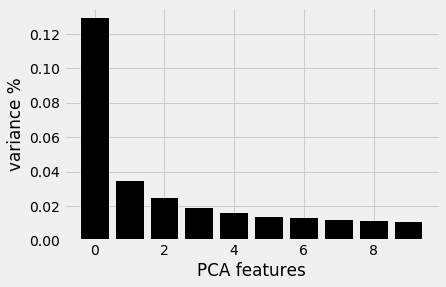

In [161]:
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.show()

In [162]:
pca_result = pd.DataFrame(pca_samples)
pca_result.head()

,0,1,2,3,4,5,6,7,8,9
0,-2.091065,0.394130,1.411408,-0.152453,0.289337,-0.398128,-0.851879,0.574399,0.837060,0.819120
1,0.040874,-0.331205,2.351727,-0.167865,-0.239478,1.057441,-0.562692,0.367385,0.863460,-0.560551
2,-1.788060,-0.393071,0.607896,-0.013568,-0.429543,0.174188,0.389140,0.384560,0.042872,-0.007869
3,-2.852527,0.157760,0.061280,0.080093,0.488984,0.243758,0.402683,0.314042,-0.102067,-0.163152
4,-2.558339,-0.392817,-0.103419,-0.108004,-0.078952,-0.104398,0.108360,0.032322,-0.156244,-0.064069


In [163]:
# Choosing k = 3 ?

## K-Means
Using PCA results

In [164]:
#pip install kneed

In [165]:
from sklearn.cluster import KMeans
from kneed import KneeLocator

In [166]:
# running iterations of kmeans - takes a while

sse = []
for k in range(1,11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(pca_result)
    sse.append(kmeans.inertia_)

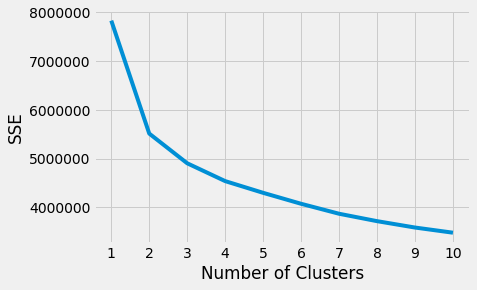

In [167]:
# elbow plot
plt.style.use("fivethirtyeight")
plt.plot(range(1,11), sse)
plt.xticks(range(1,11))
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.show()

In [168]:
# using kneed package to locate elbow point
kl = KneeLocator(range(1,11),sse,curve='convex',direction='decreasing')
kl.elbow

3

In [169]:
kmeans3 = KMeans(n_clusters=3).fit_predict(pca_result)

In [170]:
# aggregating pca and k-means result into one dataframe
customer_segment = pd.concat([cust_pur.reset_index(drop=True), pca_result.iloc[:,0:3]],axis = 1)
customer_segment.columns.values[-3:] = ['PC1', 'PC2', 'PC3']
customer_segment['Kmeans Cluster'] = kmeans3
customer_segment.head()

,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt,PC1,PC2,PC3,Kmeans Cluster
0,-0.132137,-0.331369,-0.074269,-0.112044,-0.166422,-0.152402,-0.414774,-0.19989,-0.109956,-0.077704,...,-0.132684,-0.204075,-0.197966,-0.361938,-0.084979,-0.328440,-2.091065,0.394130,1.411408,0
1,-0.132137,0.899033,-0.074269,-0.112044,-0.166422,-0.152402,0.108839,-0.19989,-0.109956,-0.077704,...,-0.132684,-0.204075,-0.197966,-0.184560,-0.084979,1.899905,0.040874,-0.331205,2.351727,0
2,-0.132137,-0.331369,-0.074269,-0.112044,-0.166422,-0.152402,-0.414774,-0.19989,-0.109956,-0.077704,...,-0.132684,-0.204075,-0.197966,-0.184560,-0.084979,-0.382790,-1.788060,-0.393071,0.607896,0
3,-0.132137,-0.331369,-0.074269,-0.112044,-0.166422,-0.152402,-0.414774,-0.19989,-0.109956,-0.077704,...,-0.132684,-0.204075,-0.197966,-0.273249,-0.084979,-0.382790,-2.852527,0.157760,0.061280,0
4,-0.132137,0.488899,-0.074269,-0.112044,-0.166422,-0.152402,-0.414774,-0.19989,-0.109956,-0.077704,...,-0.132684,-0.204075,-0.197966,-0.361938,-0.084979,-0.219740,-2.558339,-0.392817,-0.103419,0


In [171]:
customer_segment['Cluster'] = customer_segment['Kmeans Cluster'].map({0: 'One',
                                                                     1: 'Two',
                                                                     2: 'Three'})

In [172]:
customer_segment.head()

,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt,PC1,PC2,PC3,Kmeans Cluster,Cluster
0,-0.132137,-0.331369,-0.074269,-0.112044,-0.166422,-0.152402,-0.414774,-0.19989,-0.109956,-0.077704,...,-0.204075,-0.197966,-0.361938,-0.084979,-0.328440,-2.091065,0.394130,1.411408,0,One
1,-0.132137,0.899033,-0.074269,-0.112044,-0.166422,-0.152402,0.108839,-0.19989,-0.109956,-0.077704,...,-0.204075,-0.197966,-0.184560,-0.084979,1.899905,0.040874,-0.331205,2.351727,0,One
2,-0.132137,-0.331369,-0.074269,-0.112044,-0.166422,-0.152402,-0.414774,-0.19989,-0.109956,-0.077704,...,-0.204075,-0.197966,-0.184560,-0.084979,-0.382790,-1.788060,-0.393071,0.607896,0,One
3,-0.132137,-0.331369,-0.074269,-0.112044,-0.166422,-0.152402,-0.414774,-0.19989,-0.109956,-0.077704,...,-0.204075,-0.197966,-0.273249,-0.084979,-0.382790,-2.852527,0.157760,0.061280,0,One
4,-0.132137,0.488899,-0.074269,-0.112044,-0.166422,-0.152402,-0.414774,-0.19989,-0.109956,-0.077704,...,-0.204075,-0.197966,-0.361938,-0.084979,-0.219740,-2.558339,-0.392817,-0.103419,0,One


/Users/susannahschulze/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


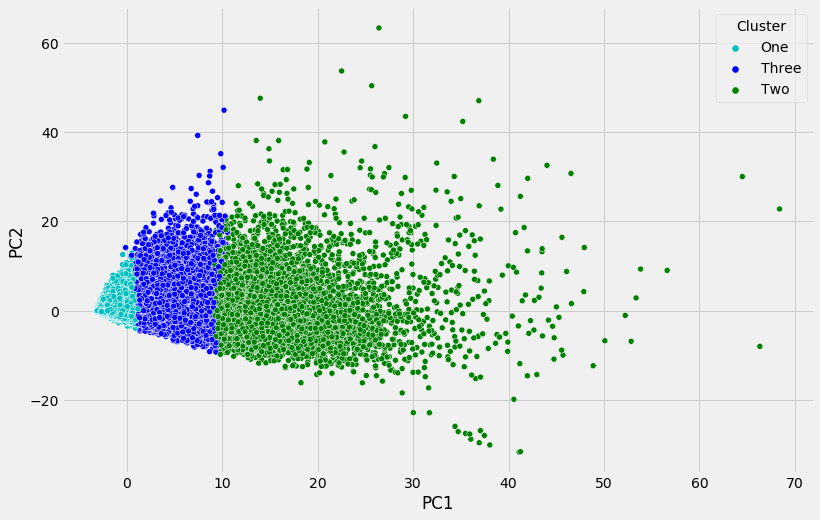

In [173]:
# visualizing results by principal components 
x = customer_segment['PC1']
y = customer_segment['PC2']
plt.figure(figsize = (12,8))
sns.scatterplot(x, y, hue = customer_segment['Cluster'], palette = ['c', 'b', 'g'])
plt.show()

## Random Forest

In [4]:
all_orders = orders.merge(orders_products, on = 'order_id', how = 'left')

In [5]:
all_orders = all_orders.merge(prod_dept_aisle, on = 'product_id', how = 'left')

In [6]:
all_orders = all_orders.fillna(0)
all_orders

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department,aisle
0,2539329,1,prior,1,2,8,0.0,196.0,1.0,0.0,Soda,77.0,7.0,beverages,soft drinks
1,2539329,1,prior,1,2,8,0.0,14084.0,2.0,0.0,Organic Unsweetened Vanilla Almond Milk,91.0,16.0,dairy eggs,soy lactosefree
2,2539329,1,prior,1,2,8,0.0,12427.0,3.0,0.0,Original Beef Jerky,23.0,19.0,snacks,popcorn jerky
3,2539329,1,prior,1,2,8,0.0,26088.0,4.0,0.0,Aged White Cheddar Popcorn,23.0,19.0,snacks,popcorn jerky
4,2539329,1,prior,1,2,8,0.0,26405.0,5.0,0.0,XL Pick-A-Size Paper Towel Rolls,54.0,17.0,household,paper goods
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33894101,272231,206209,train,14,6,14,30.0,40603.0,4.0,0.0,Fabric Softener Sheets,75.0,17.0,household,laundry
33894102,272231,206209,train,14,6,14,30.0,15655.0,5.0,0.0,Dark Chocolate Mint Snacking Chocolate,45.0,19.0,snacks,candy chocolate
33894103,272231,206209,train,14,6,14,30.0,42606.0,6.0,0.0,Phish Food Frozen Yogurt,37.0,1.0,frozen,ice cream ice
33894104,272231,206209,train,14,6,14,30.0,37966.0,7.0,0.0,French Baguette Bread,112.0,3.0,bakery,bread


In [7]:
all_prior = all_orders[all_orders.eval_set=="prior"]
all_prior = all_prior.drop(columns=['eval_set'])
all_train = all_orders[all_orders.eval_set=="train"]
all_train = all_train.drop(columns=['eval_set'])
all_test = all_orders[all_orders.eval_set=="test"]
all_test = all_test[['order_id', 'user_id', 'order_number']]

In [8]:
# Create some extra parameters
user_total_orders = all_prior.groupby('user_id')['order_number'].max().to_frame('user_total_orders').reset_index()
user_reorders = all_prior.groupby('user_id')['reordered'].max().to_frame('user_reorders').reset_index()
product_total = all_prior.groupby('product_id')['order_id'].count().to_frame('product_total').reset_index()
product_reorder = all_prior.groupby('product_id')['reordered'].mean().to_frame('product_reorder').reset_index()
avg_order_interval = all_prior.groupby('user_id')['days_since_prior_order'].mean().to_frame('avg_order_interval').reset_index()

In [9]:
# Merge into training set
all_train = all_train.merge(user_total_orders, on = 'user_id', how = 'left')
all_train = all_train.merge(user_reorders, on = 'user_id', how = 'left')
all_train = all_train.merge(product_total, on = 'product_id', how = 'left')
all_train = all_train.merge(product_reorder, on = 'product_id', how = 'left')
all_train = all_train.merge(avg_order_interval, on = 'user_id', how = 'left')

In [10]:
all_train = all_train.drop(columns=['order_id', 'product_name', 'aisle', 'department'])
all_train

,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,aisle_id,department_id,user_total_orders,user_reorders,product_total,product_reorder,avg_order_interval
0,1,11,4,8,14.0,196.0,1.0,1.0,77.0,7.0,10,1.0,35791.0,0.776480,18.542373
1,1,11,4,8,14.0,25133.0,2.0,1.0,21.0,16.0,10,1.0,6196.0,0.740155,18.542373
2,1,11,4,8,14.0,38928.0,3.0,1.0,120.0,16.0,10,1.0,13238.0,0.827769,18.542373
3,1,11,4,8,14.0,26405.0,4.0,1.0,54.0,17.0,10,1.0,1214.0,0.441516,18.542373
4,1,11,4,8,14.0,39657.0,5.0,1.0,45.0,19.0,10,1.0,5019.0,0.766288,18.542373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1384612,206209,14,6,14,30.0,40603.0,4.0,0.0,75.0,17.0,13,1.0,760.0,0.213158,18.232558
1384613,206209,14,6,14,30.0,15655.0,5.0,0.0,45.0,19.0,13,1.0,1601.0,0.533417,18.232558
1384614,206209,14,6,14,30.0,42606.0,6.0,0.0,37.0,1.0,13,1.0,877.0,0.467503,18.232558
1384615,206209,14,6,14,30.0,37966.0,7.0,0.0,112.0,3.0,13,1.0,2537.0,0.493496,18.232558


In [11]:
# Filter out products that have less than 50 total purchases
less_train = all_train.groupby('product_id').filter(lambda x: x.shape[0] > 50).reset_index()
less_train

,index,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,aisle_id,department_id,user_total_orders,user_reorders,product_total,product_reorder,avg_order_interval
0,0,1,11,4,8,14.0,196.0,1.0,1.0,77.0,7.0,10,1.0,35791.0,0.776480,18.542373
1,1,1,11,4,8,14.0,25133.0,2.0,1.0,21.0,16.0,10,1.0,6196.0,0.740155,18.542373
2,2,1,11,4,8,14.0,38928.0,3.0,1.0,120.0,16.0,10,1.0,13238.0,0.827769,18.542373
3,3,1,11,4,8,14.0,26405.0,4.0,1.0,54.0,17.0,10,1.0,1214.0,0.441516,18.542373
4,4,1,11,4,8,14.0,39657.0,5.0,1.0,45.0,19.0,10,1.0,5019.0,0.766288,18.542373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091644,1384611,206209,14,6,14,30.0,24852.0,3.0,1.0,24.0,4.0,13,1.0,472565.0,0.843501,18.232558
1091645,1384612,206209,14,6,14,30.0,40603.0,4.0,0.0,75.0,17.0,13,1.0,760.0,0.213158,18.232558
1091646,1384613,206209,14,6,14,30.0,15655.0,5.0,0.0,45.0,19.0,13,1.0,1601.0,0.533417,18.232558
1091647,1384615,206209,14,6,14,30.0,37966.0,7.0,0.0,112.0,3.0,13,1.0,2537.0,0.493496,18.232558


In [15]:
# Sample 1% from the original dataset since the original data was too big
small_train = less_train.sample(frac = 0.01, replace = False, random_state = 1)
small_train = small_train.drop(columns=['index'])
small_train

,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,aisle_id,department_id,user_total_orders,user_reorders,product_total,product_reorder,avg_order_interval
991994,187248,14,4,8,12.0,25931.0,11.0,1.0,123.0,4.0,13,1.0,17672.0,0.715878,11.512821
686330,129481,5,0,11,14.0,1529.0,22.0,1.0,16.0,4.0,4,1.0,8736.0,0.439332,12.372093
252501,47834,22,5,7,2.0,28358.0,2.0,1.0,105.0,13.0,21,1.0,1113.0,0.542677,11.032468
387222,72956,6,6,12,7.0,49141.0,32.0,0.0,121.0,14.0,5,1.0,2178.0,0.508264,20.909091
765705,144773,75,0,16,5.0,4313.0,12.0,1.0,53.0,16.0,74,1.0,1862.0,0.671858,4.961086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
870288,164541,20,5,17,13.0,28535.0,23.0,1.0,51.0,13.0,19,1.0,7112.0,0.581974,16.371875
1005668,189756,9,0,13,21.0,10312.0,11.0,0.0,94.0,7.0,8,1.0,4811.0,0.491998,27.055556
119289,22445,37,0,16,5.0,44116.0,7.0,0.0,98.0,7.0,36,1.0,4735.0,0.597254,9.713376
862168,163052,10,3,21,6.0,48679.0,7.0,1.0,83.0,4.0,9,1.0,51939.0,0.662469,18.025000


In [16]:
# Create training and testing dataset
from sklearn import model_selection
small_train = small_train.fillna(0)
y = small_train['product_id']
x = small_train.drop(columns=['product_id'])
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.3)

In [17]:
# Test for the best parameters
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
parameters = {
    'n_estimators' : [50,100,200],
    'max_depth': [10,20,40]
}
Grid_RF = GridSearchCV(RandomForestClassifier(random_state = 123), parameters)
Grid_RF.fit(x_train, y_train)

C:\Users\bengbengbb\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\bengbengbb\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\bengbengbb\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\bengbengbb\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\bengbengbb\anaconda3\lib\site-packages\joblib\parallel.py", line 1032, in __call__
    while self.dispatch_one_batch(iterator):
  File "C:\Us

GridSearchCV(estimator=RandomForestClassifier(random_state=123),
             param_grid={'max_depth': [10, 20, 40],
                         'n_estimators': [50, 100, 200]})

In [19]:
print ("Best score: " + str(Grid_RF.best_score_))
print ("Best parameters set:")
parameters = Grid_RF.best_params_
for n in sorted(parameters.keys()):
    print(n + ':' + str(parameters[n]))

Best score: 0.5115836412260008
Best parameters set:
max_depth:40
n_estimators:100


In [28]:
# Assessing model performane
from sklearn.metrics import multilabel_confusion_matrix
RF_model = Grid_RF.best_estimator_
y_unique = y_test.unique()
cm = multilabel_confusion_matrix(y_test, RF_model.predict(x_test), labels = y_unique)
print(cm)

[[[3272    2]
  [   1    0]]

 [[3270    0]
  [   0    5]]

 [[3268    0]
  [   0    7]]

 ...

 [[3274    0]
  [   1    0]]

 [[3274    0]
  [   1    0]]

 [[3274    0]
  [   1    0]]]


In [29]:
import sklearn.metrics as skm
print(skm.classification_report(y_test, RF_model.predict(x_test)))

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         1
        10.0       0.00      0.00      0.00         1
        34.0       1.00      0.50      0.67         2
        45.0       0.00      0.00      0.00         4
        54.0       0.00      0.00      0.00         0
       116.0       0.00      0.00      0.00         0
       117.0       0.00      0.00      0.00         1
       130.0       0.00      0.00      0.00         1
       162.0       0.00      0.00      0.00         1
       165.0       1.00      1.00      1.00         1
       169.0       0.00      0.00      0.00         1
       196.0       0.60      1.00      0.75         3
       204.0       0.00      0.00      0.00         1
       210.0       0.00      0.00      0.00         2
       246.0       0.00      0.00      0.00         1
       248.0       0.00      0.00      0.00         0
       258.0       0.00      0.00      0.00         1
       260.0       0.33    

C:\Users\bengbengbb\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\bengbengbb\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


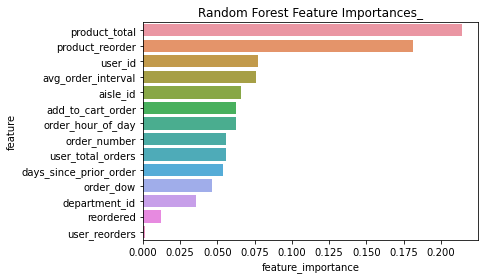

In [30]:
# Assess feature importance
# Code from https://www.kaggle.com/eangel/instacart-top-n-random-forest-model
plt.figure()
sns.barplot(data=(pd.DataFrame(data = RF_model.feature_importances_, index = x_train.columns).reset_index().
                  sort_values(by = 0,ascending = False).rename(columns = {'index': 'feature', 0: 'feature_importance'})),
            x = 'feature_importance',
            y = 'feature'
           )
plt.title('Random Forest Feature Importances_')
plt.show()